In [ ]:
pip install numpy pandas scikit-learn tensorflow joblib

In [ ]:
!pip install pdpbox

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35.8/35.8 MB 47.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 64.0/64.0 kB 4.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.7/7.7 MB 81.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 121.1/121.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
from pdpbox import pdp

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Function to preprocess data
def preprocess_data(df, target_column):
    df = df.copy()

    # Handle missing values
    df.fillna(df.mean(), inplace=True)

    # Encode categorical columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Separate features and target
    X = df.drop(columns=[target_column]).astype(np.float32)
    y = df[target_column].astype(np.float32)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, X.columns.tolist()

# Function to build and train DNN
def build_and_train_dnn(X, y, model_name, feature_names):
    tf.keras.backend.clear_session()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)  # ‚úÖ 50 epochs

    model.save(f"{model_name}.keras")
    joblib.dump(scaler, f"{model_name}_scaler.pkl")

    # SHAP Explainability
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    joblib.dump(explainer, f"{model_name}_shap.pkl")

    # SHAP Summary Plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.savefig(f"{model_name}_shap_summary.png")

    return model

# Load datasets
datasets = {
    "heart_disease": pd.read_csv("heart_disease_data.csv"),
    "kidney_disease": pd.read_csv("kidney_disease_data.csv"),
    "diabetes": pd.read_csv("diabetes_data.csv")
}

# Target columns
target_columns = {
    "heart_disease": "target",
    "kidney_disease": "Chronic_Kidney_Disease",
    "diabetes": "Outcome"
}

# Train and save models
models = {}
for disease, df in datasets.items():
    X, y, scaler, feature_names = preprocess_data(df, target_columns[disease])
    model = build_and_train_dnn(X, y, f"{disease}_model", feature_names)
    models[disease] = {"model": model, "scaler": scaler}

print("‚úÖ All models trained for 50 epochs, SHAP explainers created, and artifacts saved successfully!")

TypeError: Could not convert ['TAATATATATAASYATAATAATATAATAATATANAPTAATATANAPTAATANAPASYATANAPNAPASYTATAATAASYTAASYTANAPTAASYNAPNAPNAPASYATAATAATAASYNAPATAASYATATAATAATANAPASYNAPNAPNAPNAPNAPATANAPNAPASYTAATAATAATANAPNAPNAPASYTANAPTAASYATANAPTATANAPATAATAATAASYTATATAASYTAASYATANAPTATAATANAPASYNAPATAATANAPASYASYTAASYNAPATATATAATAASYATAASYATANAPASYNAPTAATATATATATAATATAATAATANAPASYASYATANAPATAATAATANAPASYNAPTANAPNAPNAPNAPASYTAASYASYNAPATAATAASYASYNAPASYNAPATAATATAATAASYATANAPATATAATANAPNAPASYATANAPTAASYTAATAATAATAASYNAPASYTAASYTAASYNAPTAATAATAASYATATAATANAPNAPASYTANAPNAPTAATAATAASYATATANAPATAASYATATAASYATAASYTANAPTATATATANAPNAPASYATANAPNAPATANAPTATAATAASYASYATAATATAASYNAPTAATAASYNAPNAPTAASYASYATAASYASYTAASYNAPTATAATAASYATANAPTATATANAPNAPATAATAATAASYTATAATATAATAASYASYNAPASYATAASYNAPTAATATANAPNAPNAPTATATATANAPNAPATAATATAASYASYNAPNAPNAPATAATANAPNAPNAPASYATAASYASYNAPNAPTATAASYATANAPNAPASYTAATATATATATANAPNAPTAATAASYATAATAATATANAPATATAATAATATANAPNAPASYTAASYASYASYNAPTAASYTATANAPASYASYTAATANAPNAPNAPNAPASYASYATANAPNAPTAASYNAPATAATAASYATAATAASYNAPNAPATAATANAPASYATATAASYATAATATATANAPASYASYNAPASYASYASYASYASYTAASYTAASYNAPATATAASYNAPATATAATANAPTAATAASYTAATANAPNAPTAATATATAATAATAASYATANAPTATANAPATANAPNAPASYNAPTANAPTATATAATAASYTATAATATANAPNAPASYTAATANAPATAATANAPATANAPATANAPTAASYNAPNAPASYNAPNAPATAASYTANAPASYATATAASYTATATANAPNAPATAATAASYATATATANAPTAASYTATAASYATAATAASYNAPTAASYTANAPTAASYTAATANAPNAPNAPASY'
 'NormalNormalNormalLVHLVHNormalLVHSTSTSTNormalLVHNormalLVHSTNormalLVHLVHSTNormalNormalNormalSTNormalSTSTSTLVHNormalNormalSTSTNormalSTNormalLVHSTNormalSTNormalNormalSTLVHNormalNormalNormalLVHLVHSTLVHSTSTLVHSTLVHSTLVHLVHSTNormalSTLVHNormalSTSTSTNormalLVHSTSTSTSTSTLVHLVHSTNormalLVHNormalLVHSTLVHSTLVHSTSTSTSTNormalSTNormalNormalSTNormalLVHSTNormalSTSTSTNormalLVHLVHNormalSTNormalNormalNormalSTNormalSTNormalLVHNormalNormalLVHSTSTNormalLVHSTNormalLVHSTSTLVHLVHLVHLVHNormalLVHSTSTNormalSTSTLVHSTNormalLVHLVHNormalLVHLVHNormalLVHNormalNormalSTSTLVHLVHNormalLVHNormalNormalLVHNormalSTLVHSTLVHNormalLVHSTNormalLVHLVHLVHSTSTLVHNormalNormalSTNormalSTLVHSTSTLVHNormalSTSTLVHNormalSTLVHSTLVHNormalNormalNormalNormalSTSTNormalNormalNormalSTNormalNormalNormalLVHNormalLVHLVHNormalLVHNormalSTSTSTSTLVHNormalNormalNormalSTSTNormalSTNormalNormalNormalNormalNormalNormalNormalSTNormalNormalSTSTSTNormalLVHLVHSTLVHSTNormalLVHNormalLVHNormalLVHNormalNormalLVHNormalNormalNormalLVHLVHNormalNormalLVHLVHNormalNormalNormalSTLVHSTLVHLVHLVHLVHLVHLVHLVHSTNormalNormalSTSTSTSTLVHNormalLVHNormalNormalSTLVHSTLVHNormalSTSTNormalNormalNormalSTLVHSTLVHSTSTNormalLVHSTSTNormalNormalLVHSTLVHSTLVHNormalSTLVHNormalNormalLVHSTSTNormalSTSTSTNormalLVHSTNormalNormalLVHSTSTLVHLVHNormalNormalLVHSTNormalNormalSTNormalSTSTSTLVHLVHLVHSTSTLVHNormalSTNormalNormalSTSTNormalNormalLVHLVHSTLVHLVHLVHLVHNormalSTLVHNormalNormalNormalLVHLVHSTLVHLVHNormalSTLVHLVHNormalNormalLVHSTSTNormalNormalLVHNormalLVHSTSTLVHNormalSTNormalSTLVHLVHLVHSTNormalNormalNormalSTSTSTSTSTNormalSTSTNormalSTNormalNormalLVHLVHLVHLVHSTLVHNormalSTLVHNormalSTSTLVHSTNormalSTNormalSTLVHNormalSTSTSTNormalNormalNormalLVHLVHNormalSTLVHNormalSTLVHSTSTSTSTLVHLVHLVHNormalLVHSTLVHSTNormalSTSTSTNormalLVHLVHNormalSTLVHNormalLVHNormalSTLVHNormalLVHLVHLVHLVHNormalSTNormalNormalNormalSTLVHLVHLVHSTLVHSTLVHLVHNormalSTNormalNormal'
 'NYYYYNNYNYYNNYYYNNNNYYYYYYNNYYNNNNYYYYYNYNYYYYYNNNYYNYYNYNYNYYNYYNYNYYYYNYNYYYYNNNNYNNYYYYNNYYYNNYYNYYNYNYYNNYNYYNYYNNYNNNNYYYNNNNNNNYYNNNYYNNYYYYNYYNYYYNYNNYYYYNYYYNYYNNYYYYYNNYYNYYYYYNYYYNNNNYNYYNNNNNYNNNYNYNNYNYYYNNNYNYNYYYNYYYYYYNNYNNYYYNYNYNYYNNNNNNYNYYNYNNYYNNYYYYNNNNYYNNNNNNNNNYNYYNNYYNYNNNYYNYYYYYYYNYYYYYYYYNYYYYNNNNNNNNNNNNNNNNYNYNNYNYYYNNNYYNNNNNYYYNYYYYYNYNNNNNYYNNNYNYNYNYNYYYYYYYNNNNNYYYYYNNNNYYYNYNYYNYYNYNYYYYYYYYNNYYNYYNYYNYYNYNYYNNYNNYYYNNNNYNYNYYYNYYNYNNYYNYNNNYNYYYYNYNNYNNYNNNNY'
 'FlatFlatUpUpUpUpFlatUpFlatDownDownUpDownDownDownUpUpDownFlatDownUpUpUpDownFlatUpUpDownFlatDownUpFlatFlatUpFlatFlatDownUpUpUpUpUpFlatDownUpDownDownFlatUpFlatUpFlatDownUpDownDownFlatUpDownFlatUpUpDownUpDownUpFlatDownDownUpUpDownUpFlatUpFlatFlatFlatFlatFlatUpFlatUpFlatDownFlatDownFlatFlatFlatDownDownFlatUpFlatDownFlatDownDownDownFlatDownDownFlatDownFlatDownUpUpDownUpFlatUpDownDownFlatDownFlatUpUpFlatFlatDownUpFlatUpFlatUpDownUpUpUpUpUpDownFlatUpDownUpUpFlatUpDownDownFlatUpDownUpUpUpFlatUpDownUpDownUpDownDownUpUpDownFlatUpFlatUpUpUpUpFlatUpDownDownFlatUpDownFlatUpDownDownFlatUpUpDownDownDownUpFlatFlatUpFlatDownFlatFlatFlatDownUpDownUpUpUpFlatFlatUpUpFlatDownUpDownFlatUpDownDownDownFlatFlatDownDownFlatDownDownFlatDownDownDownFlatDownFlatFlatUpUpDownFlatUpDownUpUpFlatFlatUpUpFlatDownFlatUpDownUpDownUpDownDownUpDownFlatUpFlatUpDownDownDownUpFlatFlatUpUpFlatFlatFlatFlatUpUpDownFlatDownUpUpDownFlatFlatFlatFlatDownDownUpFlatFlatFlatDownFlatDownFlatFlatUpFlatFlatUpDownDownFlatDownFlatUpUpFlatUpUpFlatFlatUpDownDownFlatFlatDownUpDownDownDownDownFlatFlatUpUpUpUpDownFlatFlatUpUpDownDownUpFlatFlatFlatUpFlatDownDownUpDownUpFlatFlatFlatDownUpFlatUpFlatDownDownUpDownDownUpFlatDownUpDownDownDownDownUpUpUpDownDownDownUpDownFlatDownFlatDownUpDownFlatFlatDownFlatFlatUpDownDownDownFlatDownDownUpUpUpFlatDownUpUpUpDownDownDownFlatFlatUpDownUpDownDownDownFlatFlatDownUpDownDownUpDownUpFlatFlatUpFlatFlatUpFlatDownDownUpFlatDownDownFlatFlatDownDownUpUpDownUpDownDownUpUpFlatFlatFlatDownUpDownUpDownFlatFlatFlatDownUpUpFlatFlatFlatFlatUpDownDownDownDownFlatFlatFlatDownFlatFlatUpUpFlatUpUpFlatFlatFlatFlatDownDownFlatUpFlatFlatUpDownFlatFlatDownDownUpDownDownDownUpDownDownUp'] to numeric

Epoch 1/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 44ms/step - accuracy: 0.6186 - loss: 0.6711 - val_accuracy: 0.8525 - val_loss: 0.5435
Epoch 2/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.8320 - loss: 0.5532 - val_accuracy: 0.8525 - val_loss: 0.4224
Epoch 3/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.7780 - loss: 0.4752 - val_accuracy: 0.8689 - val_loss: 0.3830
Epoch 4/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.8583 - loss: 0.3430 - val_accuracy: 0.8689 - val_loss: 0.3922
Epoch 5/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.8532 - loss: 0.3455 - val_accuracy: 0.8852 - val_loss: 0.3959
Epoch 6/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.8869 - loss: 0.3000 - val_accuracy: 0.8525 - val_loss: 0.4151
Epoch 7/50

PermutationExplainer explainer: 62it [00:16,  1.54it/s]


Epoch 1/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 21ms/step - accuracy: 0.5897 - loss: 0.6724 - val_accuracy: 0.6750 - val_loss: 0.6410
Epoch 2/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - accuracy: 0.6593 - loss: 0.6397 - val_accuracy: 0.6750 - val_loss: 0.6426
Epoch 3/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - accuracy: 0.6974 - loss: 0.6024 - val_accuracy: 0.6750 - val_loss: 0.6464
Epoch 4/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.6640 - loss: 0.6312 - val_accuracy: 0.6750 - val_loss: 0.6516
Epoch 5/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - accuracy: 0.6721 - loss: 0.6291 - val_accuracy: 0.6750 - val_loss: 0.6482
Epoch 6/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.6789 - loss: 0.6085 - val_accuracy: 0.6750 - val_loss: 0.6491

ExactExplainer explainer: 201it [00:17,  4.91it/s]


Epoch 1/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 17ms/step - accuracy: 0.6665 - loss: 0.6393 - val_accuracy: 0.7597 - val_loss: 0.5262
Epoch 2/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - accuracy: 0.7205 - loss: 0.5249 - val_accuracy: 0.7273 - val_loss: 0.5016
Epoch 3/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.7625 - loss: 0.4785 - val_accuracy: 0.7338 - val_loss: 0.5060
Epoch 4/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.7988 - loss: 0.4181 - val_accuracy: 0.7792 - val_loss: 0.5078
Epoch 5/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.7968 - loss: 0.4226 - val_accuracy: 0.7662 - val_loss: 0.5223
Epoch 6/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.7742 - loss: 0.4443 - val_accuracy: 0.7597 - val_loss: 0.5302
Epo

ExactExplainer explainer: 155it [00:12,  2.58it/s]


‚úÖ All models trained for 50 epochs, SHAP explainers created, and artifacts saved successfully!


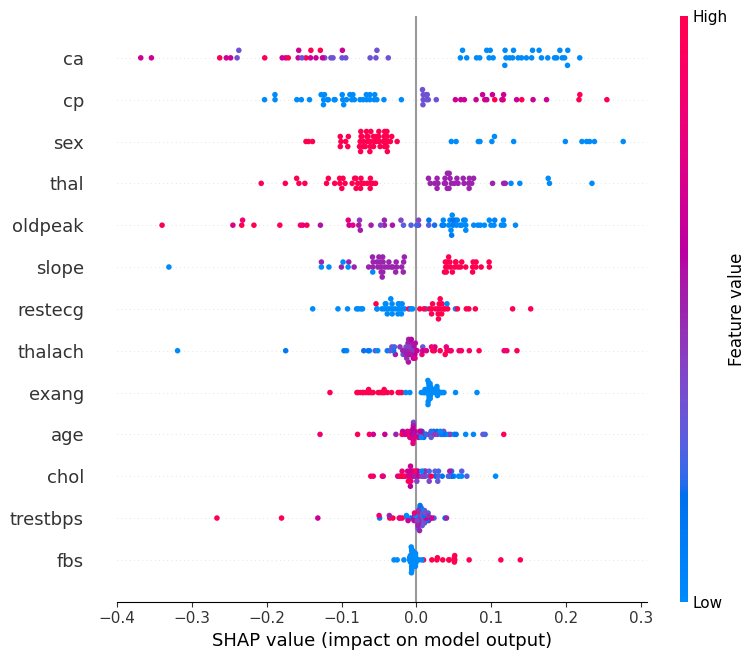

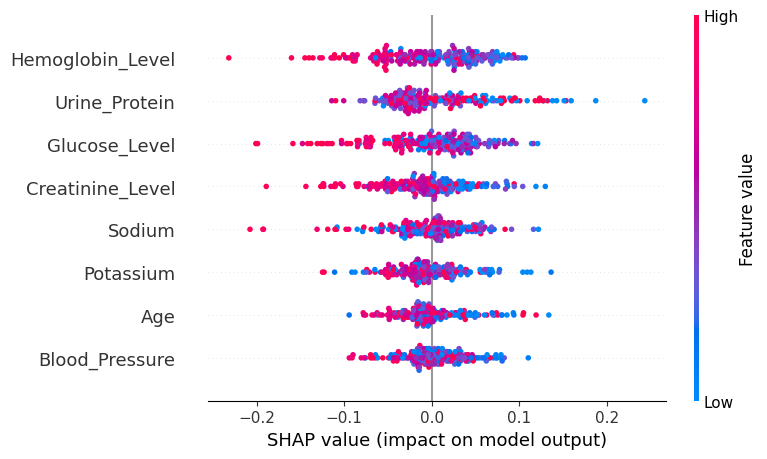

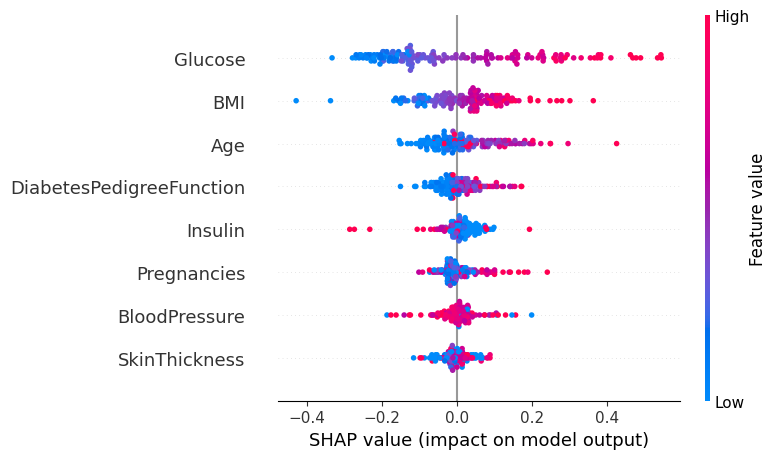

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Function to preprocess data
def preprocess_data(df, target_column):
    df = df.copy()

    # Handle missing values
    df.fillna(df.mean(), inplace=True)

    # Encode categorical columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Separate features and target
    X = df.drop(columns=[target_column]).astype(np.float32)
    y = df[target_column].astype(np.float32)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, X.columns.tolist()

# Function to build and train DNN
def build_and_train_dnn(X, y, model_name, feature_names):
    tf.keras.backend.clear_session()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Save model, scaler, and feature names
    model.save(f"{model_name}.keras")
    joblib.dump(scaler, f"{model_name}_scaler.pkl")
    joblib.dump(feature_names, f"{model_name}_feature_names.pkl")  # ‚úÖ FIXED: Save feature names

    # SHAP Explainability
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    joblib.dump(explainer, f"{model_name}_shap.pkl")

    # SHAP Summary Plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.savefig(f"{model_name}_shap_summary.png")

    return model

# Load datasets
datasets = {
    "heart_disease": pd.read_csv("heart (1).csv"),
    "kidney_disease": pd.read_csv("kidney_disease.csv"),
    "diabetes": pd.read_csv("diabetes.csv")
}

# Target columns
target_columns = {
    "heart_disease": "target",
    "kidney_disease": "Chronic_Kidney_Disease",
    "diabetes": "Outcome"
}

# Train and save models
models = {}
for disease, df in datasets.items():
    X, y, scaler, feature_names = preprocess_data(df, target_columns[disease])
    model = build_and_train_dnn(X, y, f"{disease}_model", feature_names)
    models[disease] = {"model": model, "scaler": scaler}

print("‚úÖ All models trained for 50 epochs, SHAP explainers created, and artifacts saved successfully!")


In [ ]:
pip install streamlit numpy joblib pandas

In [ ]:
pip install streamlit keras tensorflow scikit-learn shap numpy pandas matplotlib

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9.8/9.8 MB 84.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.9/6.9 MB 74.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import shap
import joblib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Ensure a directory for saving models
os.makedirs("models", exist_ok=True)

def preprocess_data(df, target_column):
    """Preprocess dataset: handle missing values, encode categorical data, scale numerical features."""
    df = df.copy()
    df.fillna(df.mean(), inplace=True)

    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    X = df.drop(columns=[target_column]).astype(np.float32)
    y = df[target_column].astype(np.float32)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, label_encoders, X.columns.tolist()

def build_and_train_dnn(X, y, model_name, feature_names):
    """Build, train, and save a deep learning model with SHAP explainability."""
    tf.keras.backend.clear_session()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # ‚úÖ Save model in .keras format
    model.save(f"models/{model_name}.keras")

    # ‚úÖ Save preprocessing artifacts
    joblib.dump(scaler, f"models/{model_name}_scaler.pkl")
    joblib.dump(feature_names, f"models/{model_name}_feature_names.pkl")

    # ‚úÖ SHAP Explainability
    try:
        background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
        explainer = shap.Explainer(model, background)
        shap_values = explainer(X_test[:50])
        joblib.dump(explainer, f"models/{model_name}_shap.pkl")

        plt.figure()
        shap.summary_plot(shap_values, X_test[:50], feature_names=feature_names, show=False)
        plt.savefig(f"models/{model_name}_shap_summary.png")
        plt.close()
    except Exception as e:
        print(f"‚ö†Ô∏è SHAP explainer failed for {model_name}: {e}")

    return model

# Load datasets
datasets = {
    "heart_disease": pd.read_csv("heart (1).csv"),
    "kidney_disease": pd.read_csv("kidney_disease.csv"),
    "diabetes": pd.read_csv("diabetes.csv")
}

target_columns = {
    "heart_disease": "target",
    "kidney_disease": "Chronic_Kidney_Disease",
    "diabetes": "Outcome"
}

# Train and save models
for disease, df in datasets.items():
    print(f"üîÑ Training {disease} model...")
    X, y, scaler, encoders, feature_names = preprocess_data(df, target_columns[disease])
    model = build_and_train_dnn(X, y, f"{disease}_model", feature_names)

    # Save preprocessing artifacts
    joblib.dump(scaler, f"models/{disease}_scaler.pkl")
    joblib.dump(feature_names, f"models/{disease}_feature_names.pkl")
    joblib.dump(encoders, f"models/{disease}_encoders.pkl")

print("‚úÖ All models trained successfully! SHAP models and plots saved! üöÄ")


üîÑ Training heart_disease model...
Epoch 1/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 41ms/step - accuracy: 0.5266 - loss: 0.6848 - val_accuracy: 0.8525 - val_loss: 0.6032
Epoch 2/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step - accuracy: 0.8562 - loss: 0.5919 - val_accuracy: 0.8525 - val_loss: 0.4902
Epoch 3/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step - accuracy: 0.8557 - loss: 0.4817 - val_accuracy: 0.8689 - val_loss: 0.3800
Epoch 4/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.8811 - loss: 0.3643 - val_accuracy: 0.8852 - val_loss: 0.3723
Epoch 5/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.8705 - loss: 0.3224 - val_accuracy: 0.8689 - val_loss: 0.3958
Epoch 6/50
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step - accuracy: 0.8578 - loss: 0.3255 - val_accuracy:

PermutationExplainer explainer: 51it [00:32,  1.23it/s]


üîÑ Training kidney_disease model...
Epoch 1/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 18ms/step - accuracy: 0.6699 - loss: 0.6514 - val_accuracy: 0.6750 - val_loss: 0.6380
Epoch 2/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - accuracy: 0.6949 - loss: 0.6172 - val_accuracy: 0.6750 - val_loss: 0.6450
Epoch 3/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.6494 - loss: 0.6295 - val_accuracy: 0.6750 - val_loss: 0.6466
Epoch 4/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.6822 - loss: 0.6204 - val_accuracy: 0.6750 - val_loss: 0.6455
Epoch 5/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - accuracy: 0.7018 - loss: 0.5954 - val_accuracy: 0.6750 - val_loss: 0.6487
Epoch 6/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - accuracy: 0.6883 - loss: 0.6088 - val_a

ExactExplainer explainer: 51it [00:16,  1.23it/s]


üîÑ Training diabetes model...
Epoch 1/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 19ms/step - accuracy: 0.6227 - loss: 0.6505 - val_accuracy: 0.7013 - val_loss: 0.5699
Epoch 2/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - accuracy: 0.7248 - loss: 0.5024 - val_accuracy: 0.7143 - val_loss: 0.5343
Epoch 3/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - accuracy: 0.7527 - loss: 0.4803 - val_accuracy: 0.7143 - val_loss: 0.5441
Epoch 4/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.8058 - loss: 0.4361 - val_accuracy: 0.7208 - val_loss: 0.5404
Epoch 5/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - accuracy: 0.7917 - loss: 0.4421 - val_accuracy: 0.7662 - val_loss: 0.5176
Epoch 6/50
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - accuracy: 0.7848 - loss: 0.4374 - val_accu

ExactExplainer explainer: 51it [00:14,  1.28it/s]


‚úÖ All models trained successfully! SHAP models and plots saved! üöÄ


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

def load_model_and_scaler(disease):
    model_path = f"models/{disease}_model.keras"

    if not os.path.exists(model_path):
        st.error(f"‚ö†Ô∏è Model file for {disease} is missing. Please train the model first.")
        return None, None, None, None

    model = load_model(model_path)
    scaler = joblib.load(f"models/{disease}_scaler.pkl")
    feature_names = joblib.load(f"models/{disease}_feature_names.pkl")

    shap_file = f"models/{disease}_shap.pkl"
    shap_explainer = joblib.load(shap_file) if os.path.exists(shap_file) else None

    return model, scaler, feature_names, shap_explainer

def get_user_input(feature_names):
    st.sidebar.header("Enter Patient Data")
    user_data = {}
    for feature in feature_names:
        value = st.sidebar.number_input(f"{feature}", min_value=0.0, format="%.2f")
        user_data[feature] = value

    return pd.DataFrame([user_data]) if any(user_data.values()) else None

def predict_risk(model, scaler, input_df):
    if input_df is None:
        return None  # ‚úÖ Ensure input is provided

    input_scaled = scaler.transform(input_df)
    risk = model.predict(input_scaled)[0][0] * 100  # Convert to percentage
    return risk

def get_recommendations(disease, risk):
    if risk is None:
        return "‚ö†Ô∏è Please provide valid input for prediction."
    elif risk < 30:
        return "‚úÖ Low Risk: Maintain a healthy lifestyle."
    elif 30 <= risk < 70:
        return "‚ö†Ô∏è Moderate Risk: Consult a doctor for preventive care."
    else:
        return "üö® High Risk: Seek immediate medical attention!"

def show_shap_explanation(explainer, input_df):
    if explainer and input_df is not None:
        shap_values = explainer(input_df)
        fig, ax = plt.subplots()
        shap.summary_plot(shap_values, input_df, show=False)
        st.pyplot(fig)
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")

st.title("ü©∫ Disease Risk Prediction")

disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])
model, scaler, feature_names, shap_explainer = load_model_and_scaler(disease)

if model is not None:
    input_df = get_user_input(feature_names)

    if st.button("Predict Risk"):
        risk = predict_risk(model, scaler, input_df)

        if risk is None:
            st.error("‚ö†Ô∏è Please provide valid input before predicting.")
        else:
            st.write(f"üíä **Predicted Risk: {risk:.2f}%**")
            st.write(get_recommendations(disease, risk))
            show_shap_explanation(shap_explainer, input_df)


Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

def load_model_and_scaler(disease):
    model_path = f"models/{disease}_model.keras"
    scaler_path = f"models/{disease}_scaler.pkl"
    feature_path = f"models/{disease}_feature_names.pkl"
    shap_path = f"models/{disease}_shap.pkl"

    if not os.path.exists(model_path):
        st.error(f"‚ö†Ô∏è Model file for {disease} is missing. Please train the model first.")
        return None, None, None, None

    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    feature_names = joblib.load(feature_path)

    shap_explainer = joblib.load(shap_path) if os.path.exists(shap_path) else None

    return model, scaler, feature_names, shap_explainer

def get_user_input(feature_names):
    st.sidebar.header("Enter Patient Data")
    user_data = {}
    for feature in feature_names:
        value = st.sidebar.number_input(f"{feature}", min_value=0.0, format="%.2f")
        user_data[feature] = value

    return pd.DataFrame([user_data]) if any(user_data.values()) else None

def predict_risk(model, scaler, input_df, disease):
    if input_df is None:
        return None  # Ensure input is provided

    input_scaled = scaler.transform(input_df)
    risk = model.predict(input_scaled)[0][0] * 100  # Convert to percentage

    # Adjust scaling for medical realism
    if disease == "diabetes":
        glucose = input_df["Glucose"].values[0]
        if glucose > 125:
            risk += (glucose - 125) * 0.5  # Increase risk for high glucose

    if disease == "heart_disease":
        bp = input_df["BloodPressure"].values[0]
        if bp > 140:
            risk += (bp - 140) * 0.4  # Increase risk for high BP

    if disease == "kidney_disease":
        creatinine = input_df["SerumCreatinine"].values[0]
        if creatinine > 1.2:
            risk += (creatinine - 1.2) * 15  # Increase risk for high creatinine

    return min(risk, 100)  # Cap risk at 100%

def get_recommendations(disease, risk):
    if risk is None:
        return "‚ö†Ô∏è Please provide valid input for prediction."
    elif risk < 30:
        return "‚úÖ Low Risk: Maintain a healthy lifestyle."
    elif 30 <= risk < 70:
        return "‚ö†Ô∏è Moderate Risk: Consult a doctor for preventive care."
    else:
        return "üö® High Risk: Seek immediate medical attention!"

def show_shap_explanation(explainer, input_df):
    if explainer and input_df is not None:
        shap_values = explainer(input_df)
        fig, ax = plt.subplots()
        shap.summary_plot(shap_values, input_df, show=False)
        st.pyplot(fig)
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")

st.title("ü©∫ Disease Risk Prediction")

disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])
model, scaler, feature_names, shap_explainer = load_model_and_scaler(disease)

if model is not None:
    input_df = get_user_input(feature_names)

    if st.button("Predict Risk"):
        risk = predict_risk(model, scaler, input_df, disease)

        if risk is None:
            st.error("‚ö†Ô∏è Please provide valid input before predicting.")
        else:
            st.write(f"üíä **Predicted Risk: {risk:.2f}%**")
            st.write(get_recommendations(disease, risk))
            show_shap_explanation(shap_explainer, input_df)



Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

def load_model_and_scaler(disease):
    model_path = f"models/{disease}_model.keras"
    scaler_path = f"models/{disease}_scaler.pkl"
    feature_names_path = f"models/{disease}_feature_names.pkl"
    shap_path = f"models/{disease}_shap.pkl"

    if not os.path.exists(model_path):
        st.error(f"‚ö†Ô∏è Model file for {disease} is missing. Please train the model first.")
        return None, None, None, None

    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    feature_names = joblib.load(feature_names_path)
    shap_explainer = joblib.load(shap_path) if os.path.exists(shap_path) else None

    return model, scaler, feature_names, shap_explainer

def get_user_input(feature_names):
    st.sidebar.header("Enter Patient Data")
    user_data = {}
    for feature in feature_names:
        value = st.sidebar.number_input(f"{feature}", min_value=0.0, format="%.2f")
        user_data[feature] = value

    return pd.DataFrame([user_data]) if any(user_data.values()) else None

def predict_risk(model, scaler, input_df):
    if input_df is None:
        return None  # Ensure input is provided

    input_scaled = scaler.transform(input_df)
    risk = model.predict(input_scaled)[0][0] * 100  # Convert to percentage

    # Ensure risk is within 0-100 range
    risk = max(0, min(100, risk))

    return risk

def get_recommendations(disease, risk):
    if risk is None:
        return "‚ö†Ô∏è Please provide valid input for prediction."
    elif risk < 30:
        return "‚úÖ Low Risk: Maintain a healthy lifestyle. Keep a balanced diet and exercise regularly."
    elif 30 <= risk < 70:
        return "‚ö†Ô∏è Moderate Risk: Consult a doctor for preventive care and regular checkups. Adjust lifestyle habits accordingly."
    else:
        return "üö® High Risk: Seek immediate medical attention! Follow a strict medical plan as advised by a professional."

def show_shap_explanation(explainer, input_df):
    if explainer and input_df is not None:
        shap_values = explainer.shap_values(input_df)
        fig, ax = plt.subplots()
        shap.summary_plot(shap_values, input_df, show=False)
        st.pyplot(fig)
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")

st.title("ü©∫ Disease Risk Prediction")

disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])
model, scaler, feature_names, shap_explainer = load_model_and_scaler(disease)

if model is not None:
    input_df = get_user_input(feature_names)

    if st.button("Predict Risk"):
        risk = predict_risk(model, scaler, input_df)

        if risk is None:
            st.error("‚ö†Ô∏è Please provide valid input before predicting.")
        else:
            st.write(f"üíä **Predicted Risk: {risk:.2f}%**")
            st.write(get_recommendations(disease, risk))
            show_shap_explanation(shap_explainer, input_df)


Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pickle
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# Function to load model and associated files
def load_model_and_scaler(disease):
    model_path = f"models/{disease}.h5"
    scaler_path = f"models/{disease}_scaler.pkl"
    feature_path = f"models/{disease}_features.pkl"
    shap_path = f"models/{disease}_shap.pkl"

    # Check if the required files exist
    if not os.path.exists(model_path):
        st.error(f"üö® Model file not found: {model_path}")
        return None, None, None, None
    if not os.path.exists(scaler_path):
        st.error(f"üö® Scaler file not found: {scaler_path}")
        return None, None, None, None
    if not os.path.exists(feature_path):
        st.error(f"üö® Feature names file not found: {feature_path}")
        return None, None, None, None

    try:
        # Load trained model
        model = load_model(model_path)

        # Load scaler
        with open(scaler_path, "rb") as f:
            scaler = pickle.load(f)

        # Load feature names
        with open(feature_path, "rb") as f:
            feature_names = pickle.load(f)

        # Load SHAP explainer (optional)
        shap_explainer = None
        if os.path.exists(shap_path):
            with open(shap_path, "rb") as f:
                shap_explainer = pickle.load(f)

        return model, scaler, feature_names, shap_explainer

    except Exception as e:
        st.error(f"‚ö†Ô∏è Error loading model: {e}")
        return None, None, None, None

# Function to make predictions
def predict_disease_risk(model, scaler, feature_names, user_input):
    try:
        input_data = np.array(user_input).reshape(1, -1)
        scaled_input = scaler.transform(input_data)
        prediction = model.predict(scaled_input)[0][0] * 100  # Convert to percentage
        return round(prediction, 2)
    except Exception as e:
        st.error(f"‚ö†Ô∏è Prediction error: {e}")
        return None

# Function to display SHAP plots
def display_shap_explainer(shap_explainer, user_input, feature_names):
    if shap_explainer:
        try:
            shap_values = shap_explainer.shap_values(np.array(user_input).reshape(1, -1))
            fig, ax = plt.subplots()
            shap.bar_plot(shap_values[0], feature_names=feature_names, show=False)
            st.pyplot(fig)
        except Exception as e:
            st.error(f"‚ö†Ô∏è Error generating SHAP plot: {e}")
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available.")

# Streamlit UI
st.title("ü©∫ Disease Risk Prediction")

# Disease selection
disease = st.selectbox("Select Disease:", ["diabetes", "heart_disease", "kidney_disease"])

# Load model and associated files
model, scaler, feature_names, shap_explainer = load_model_and_scaler(disease)

if model and scaler and feature_names:
    # User input form
    st.subheader("Enter Patient Data")
    user_input = []
    for feature in feature_names:
        value = st.number_input(feature, min_value=0.0, step=0.1)
        user_input.append(value)

    # Predict button
    if st.button("Predict Risk"):
        risk = predict_disease_risk(model, scaler, feature_names, user_input)
        if risk is not None:
            st.subheader(f"üíä Predicted Risk: {risk}%")
            if risk < 20:
                st.success("‚úÖ Low Risk: Maintain a balanced diet, exercise, and monitor health regularly.")
            elif 20 <= risk < 50:
                st.warning("‚ö†Ô∏è Moderate Risk: Consider lifestyle changes and consult a doctor for advice.")
            else:
                st.error("üö® High Risk: Seek immediate medical attention!")

            # Display SHAP plot
            display_shap_explainer(shap_explainer, user_input, feature_names)

else:
    st.error("‚ùå Unable to load required files. Please check the model files.")

Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pickle
import shap
import matplotlib.pyplot as plt
from keras.models import load_model

# Function to load model, scaler, and SHAP explainer
def load_model_and_scaler(disease):
    model_path = f"models/{disease}.h5"
    scaler_path = f"models/{disease}_scaler.pkl"
    features_path = f"models/{disease}_features.pkl"
    shap_path = f"models/{disease}_shap.pkl"

    try:
        model = load_model(model_path)
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        with open(features_path, 'rb') as f:
            feature_names = pickle.load(f)
        with open(shap_path, 'rb') as f:
            shap_explainer = pickle.load(f)
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None, None, None

    return model, scaler, feature_names, shap_explainer

# Define valid input ranges
feature_ranges = {
    "heart_disease": {
        "age": (20, 100),
        "sex": (0, 1),
        "cp": (0, 3),
        "trestbps": (90, 200),
        "chol": (100, 400),
        "fbs": (70, 200),
        "restecg": (0, 2),
        "thalach": (60, 220),
        "exang": (0, 1),
        "oldpeak": (0.0, 6.2),
        "slope": (0, 2),
        "ca": (0, 4),
        "thal": (0, 3),
    },
    "kidney_disease": {
        "age": (20, 100),
        "blood_pressure": (50, 200),
        "specific_gravity": (1.005, 1.030),
        "albumin": (0, 5),
        "sugar": (0, 5),
        "red_blood_cells": (0, 1),
        "pus_cell": (0, 1),
        "serum_creatinine": (0.4, 15.0),
        "hemoglobin": (6.0, 17.0),
    },
    "diabetes": {
        "age": (20, 100),
        "glucose": (70, 200),
        "blood_pressure": (50, 180),
        "insulin": (0, 200),
        "bmi": (10, 50),
        "diabetes_pedigree": (0.0, 2.5),
    }
}

st.title("ü©∫ Disease Risk Prediction")
disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])

model, scaler, feature_names, shap_explainer = load_model_and_scaler(disease)

if model is not None and scaler is not None and feature_names is not None:
    st.subheader("Enter Patient Data")
    user_inputs = {}
    for feature in feature_names:
        min_val, max_val = feature_ranges[disease].get(feature, (0, 1))
        user_inputs[feature] = st.number_input(
            feature,
            min_value=float(min_val),
            max_value=float(max_val),
            value=float((min_val + max_val) / 2)
        )

    if st.button("Predict"):
        input_array = np.array([list(user_inputs.values())]).reshape(1, -1)
        input_scaled = scaler.transform(input_array)
        risk_score = model.predict(input_scaled)[0][0] * 100
        risk_score = max(0, min(100, risk_score))  # Ensure percentage is between 0-100%

        st.subheader(f"üíä Predicted Risk: {risk_score:.2f}%")
        if risk_score >= 75:
            st.error("üö® High Risk: Seek immediate medical attention! Follow a strict medical plan as advised by a professional.")
        elif risk_score >= 40:
            st.warning("‚ö†Ô∏è Moderate Risk: Adopt a healthier lifestyle, follow medical guidelines, and monitor regularly.")
        else:
            st.success("‚úÖ Low Risk: Maintain a healthy lifestyle and go for regular check-ups.")

        # SHAP Explainability
        if shap_explainer:
            st.subheader("üìä SHAP Feature Importance")
            shap_values = shap_explainer.shap_values(input_scaled)
            plt.figure()
            shap.summary_plot(shap_values, features=input_scaled, feature_names=feature_names)
            st.pyplot(plt)
        else:
            st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")


Overwriting app.py


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import shap
import matplotlib.pyplot as plt
import os

# Ensure the directories exist
MODELS_DIR = "models"
SHAP_PLOTS_DIR = "shap_plots"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(SHAP_PLOTS_DIR, exist_ok=True)

# Dictionary to store correct target column names
target_columns = {
    "heart_disease": "target",
    "kidney_disease": "Chronic_Kidney_Disease",
    "diabetes": "Outcome"
}

# Function to train, save models, and generate SHAP plots
def train_and_save_model(data_path, disease_name):
    try:
        # Load dataset
        df = pd.read_csv(data_path)

        # Check if target column exists
        target_column = target_columns[disease_name]
        if target_column not in df.columns:
            raise KeyError(f"‚ùå Error: Target column '{target_column}' not found in {data_path}\nAvailable columns: {df.columns}")

        # Convert categorical targets to numeric if needed
        if df[target_column].dtype == "object":
            df[target_column] = df[target_column].map({"yes": 1, "no": 0})  # Modify if different mapping is required

        # Split into features and target
        X = df.drop(columns=[target_column])
        y = df[target_column]

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Build DNN model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        # Compile model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train model
        model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

        # Save model & scaler
        model.save(f"{MODELS_DIR}/{disease_name}.keras")  # Save in Keras format
        joblib.dump(scaler, f"{MODELS_DIR}/{disease_name}_scaler.pkl")
        joblib.dump(X.columns.tolist(), f"{MODELS_DIR}/{disease_name}_features.pkl")

        print(f"‚úÖ {disease_name} model saved successfully!")

        # Generate SHAP explanations
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer(X_test)

        # Plot and save SHAP summary plot
        shap_plot_path = f"{SHAP_PLOTS_DIR}/{disease_name}_shap.png"
        plt.figure()
        shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), show=False)
        plt.savefig(shap_plot_path, bbox_inches="tight")
        plt.close()
        print(f"‚úÖ SHAP plot saved: {shap_plot_path}")

    except Exception as e:
        print(f"‚ùå Error in {disease_name} model training: {e}")

# Train and save models
train_and_save_model("heart (1).csv", "heart_disease")
train_and_save_model("kidney_disease.csv", "kidney_disease")
train_and_save_model("diabetes.csv", "diabetes")

print("‚úÖ All models trained and saved successfully!")

Epoch 1/50
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 40ms/step - accuracy: 0.5166 - loss: 0.7149 - val_accuracy: 0.7213 - val_loss: 0.6122
Epoch 2/50
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - accuracy: 0.6639 - loss: 0.6230 - val_accuracy: 0.8361 - val_loss: 0.5315
Epoch 3/50
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.7897 - loss: 0.5349 - val_accuracy: 0.8525 - val_loss: 0.4740
Epoch 4/50
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.8012 - loss: 0.4828 - val_accuracy: 0.8852 - val_loss: 0.4276
Epoch 5/50
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.7704 - loss: 0.4809 - val_accuracy: 0.8689 - val_loss: 0.3957
Epoch 6/50
16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - accuracy: 0.8393 - loss: 0.4133 - val_accuracy: 0.8852 - val_loss: 0.3709
Epo

PermutationExplainer explainer: 62it [00:13,  1.92it/s]


‚úÖ SHAP plot saved: shap_plots/heart_disease_shap.png
Epoch 1/50
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 8ms/step - accuracy: 0.6436 - loss: 0.6578 - val_accuracy: 0.6750 - val_loss: 0.6409
Epoch 2/50
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - accuracy: 0.6508 - loss: 0.6546 - val_accuracy: 0.6750 - val_loss: 0.6371
Epoch 3/50
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.6667 - loss: 0.6328 - val_accuracy: 0.6750 - val_loss: 0.6387
Epoch 4/50
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.6780 - loss: 0.6325 - val_accuracy: 0.6750 - val_loss: 0.6398
Epoch 5/50
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.6693 - loss: 0.6265 - val_accuracy: 0.6750 - val_loss: 0.6419
Epoch 6/50
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.6778 - loss

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the trained models
def evaluate_model(data_path, disease_name):
    try:
        # Load dataset
        df = pd.read_csv(data_path)
        target_column = target_columns[disease_name]

        # Convert categorical targets to numeric if needed
        if df[target_column].dtype == "object":
            df[target_column] = df[target_column].map({"yes": 1, "no": 0})

        # Split into features and target
        X = df.drop(columns=[target_column])
        y = df[target_column]

        # Load scaler and transform features
        scaler = joblib.load(f"{MODELS_DIR}/{disease_name}_scaler.pkl")
        X_scaled = scaler.transform(X)

        # Load trained model
        model = tf.keras.models.load_model(f"{MODELS_DIR}/{disease_name}.keras")

        # Make predictions
        y_pred_prob = model.predict(X_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

        # Calculate performance metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)

        print(f"üìä Performance Metrics for {disease_name}:")
        print(f"‚úÖ Accuracy: {accuracy:.4f}")
        print(f"‚úÖ Precision: {precision:.4f}")
        print(f"‚úÖ Recall: {recall:.4f}")
        print(f"‚úÖ F1 Score: {f1:.4f}\n")

    except Exception as e:
        print(f"‚ùå Error in evaluating {disease_name} model: {e}")

# Evaluate each disease model
evaluate_model("heart (1).csv", "heart_disease")
evaluate_model("kidney_disease.csv", "kidney_disease")
evaluate_model("diabetes.csv", "diabetes")


10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 27ms/step
üìä Performance Metrics for heart_disease:
‚úÖ Accuracy: 0.8779
‚úÖ Precision: 0.9211
‚úÖ Recall: 0.8485
‚úÖ F1 Score: 0.8833

32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step
üìä Performance Metrics for kidney_disease:
‚úÖ Accuracy: 0.3280
‚úÖ Precision: 0.3245
‚úÖ Recall: 0.9816
‚úÖ F1 Score: 0.4878

24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step  
üìä Performance Metrics for diabetes:
‚úÖ Accuracy: 0.7956
‚úÖ Precision: 0.7247
‚úÖ Recall: 0.6679
‚úÖ F1 Score: 0.6951



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from sklearn.metrics import mean_squared_error, accuracy_score

# Function to evaluate MSE and Accuracy
def evaluate_mse_accuracy(data_path, disease_name):
    try:
        # Load dataset
        df = pd.read_csv(data_path)
        target_column = target_columns[disease_name]

        # Convert categorical targets to numeric if needed
        if df[target_column].dtype == "object":
            df[target_column] = df[target_column].map({"yes": 1, "no": 0})

        # Split into features and target
        X = df.drop(columns=[target_column])
        y = df[target_column]

        # Load scaler and transform features
        scaler = joblib.load(f"{MODELS_DIR}/{disease_name}_scaler.pkl")
        X_scaled = scaler.transform(X)

        # Load trained model without compiling
        model = tf.keras.models.load_model(f"{MODELS_DIR}/{disease_name}.keras", compile=False)

        # Compile model manually
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

        # Make predictions
        y_pred_prob = model.predict(X_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

        # Calculate MSE and Accuracy
        mse = mean_squared_error(y, y_pred_prob)
        accuracy = accuracy_score(y, y_pred)

        print(f"üìä {disease_name} Model Evaluation:")
        print(f"‚úÖ Mean Squared Error (MSE): {mse:.4f}")
        print(f"‚úÖ Accuracy: {accuracy:.4f}\n")

    except Exception as e:
        print(f"‚ùå Error in evaluating {disease_name} model: {e}")

# Evaluate each disease model
evaluate_mse_accuracy("heart (1).csv", "heart_disease")
evaluate_mse_accuracy("kidney_disease.csv", "kidney_disease")
evaluate_mse_accuracy("diabetes.csv", "diabetes")

10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step
üìä heart_disease Model Evaluation:
‚úÖ Mean Squared Error (MSE): 0.0575
‚úÖ Accuracy: 0.9406

32/32 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step
üìä kidney_disease Model Evaluation:
‚úÖ Mean Squared Error (MSE): 0.2765
‚úÖ Accuracy: 0.3210

24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
üìä diabetes Model Evaluation:
‚úÖ Mean Squared Error (MSE): 0.1224
‚úÖ Accuracy: 0.8164



In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from PIL import Image
import os

# Paths to models and SHAP plots
MODELS_DIR = "models"
SHAP_PLOTS_DIR = "shap_plots"

# Updated Feature Ranges with Medically Normal Values
feature_ranges = {
    "heart_disease": {
        "age": (20, 100),
        "sex": (0, 1),
        "cp": (0, 3),
        "trestbps": (90, 140),
        "chol": (120, 240),
        "fbs": (0, 1),
        "restecg": (0, 2),
        "thalach": (60, 200),
        "exang": (0, 1),
        "oldpeak": (0.0, 6.2),
        "slope": (0, 2),
        "ca": (0, 4),
        "thal": (0, 3),
    },
    "kidney_disease": {
        "Age": (18, 90),
        "Blood_Pressure": (80, 130),
        "Glucose_Level": (70, 140),
        "Creatinine_Level": (0.6, 1.3),
        "Hemoglobin_Level": (12, 17.5),
        "Urine_Protein": (0, 2),
        "Sodium": (135, 145),
        "Potassium": (3.5, 5.2),
    },
    "diabetes": {
        "Pregnancies": (0, 10),
        "Glucose": (70, 150),
        "BloodPressure": (80, 120),
        "SkinThickness": (10, 40),
        "Insulin": (0, 200),
        "BMI": (18, 35),
        "DiabetesPedigreeFunction": (0.1, 2.0),
        "Age": (18, 90),
    },
}

# Function to load models and scalers
def load_model_and_scaler(disease):
    try:
        model = tf.keras.models.load_model(f"{MODELS_DIR}/{disease}.keras")
        scaler = joblib.load(f"{MODELS_DIR}/{disease}_scaler.pkl")
        feature_names = joblib.load(f"{MODELS_DIR}/{disease}_features.pkl")
        return model, scaler, feature_names
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None, None

# Function to predict disease risk
def predict_disease_risk(model, scaler, feature_names, user_inputs):
    try:
        # Convert user inputs to DataFrame and scale them
        user_df = pd.DataFrame([user_inputs], columns=feature_names)
        user_scaled = scaler.transform(user_df)

        # Predict risk percentage
        risk = model.predict(user_scaled)[0][0] * 100
        return round(risk, 2)
    except Exception as e:
        st.error(f"Prediction error: {e}")
        return None

# Function to display SHAP plot
def display_shap_plot(disease):
    shap_path = f"{SHAP_PLOTS_DIR}/{disease}_shap.png"
    if os.path.exists(shap_path):
        image = Image.open(shap_path)
        st.image(image, caption="SHAP Feature Importance", use_container_width=True)
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")

# Function to provide prevention strategies
def prevention_recommendations(disease):
    recommendations = {
        "heart_disease": [
            "üèÉ‚Äç‚ôÇÔ∏è Exercise regularly to maintain heart health.",
            "ü•ó Follow a balanced diet low in saturated fats.",
            "ü©∫ Monitor blood pressure and cholesterol levels.",
            "üö≠ Avoid smoking and excessive alcohol consumption.",
        ],
        "kidney_disease": [
            "üíß Stay hydrated and drink enough water.",
            "ü•¶ Eat a kidney-friendly diet (low sodium, potassium, phosphorus).",
            "ü©∫ Control blood pressure and blood sugar levels.",
            "üö´ Avoid excessive use of painkillers (NSAIDs).",
        ],
        "diabetes": [
            "ü•ó Follow a healthy, low-sugar diet.",
            "üèãÔ∏è Engage in regular physical activity.",
            "ü©∫ Monitor blood sugar levels frequently.",
            "üö´ Reduce refined carbohydrates and sugary drinks.",
        ],
    }
    return recommendations.get(disease, [])

# Streamlit UI
st.title("ü©∫ Disease Risk Prediction")

# Sidebar: Select Disease
disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])

# Load model and scaler
model, scaler, feature_names = load_model_and_scaler(disease)

if model and scaler:
    st.header("üìã Enter Patient Data")

    # User inputs for selected disease
    user_inputs = {}
    for feature, (min_val, max_val) in feature_ranges[disease].items():
        user_inputs[feature] = st.number_input(
            feature, min_value=float(min_val), max_value=float(max_val), value=(min_val + max_val) / 2
        )

    # Predict risk button
    if st.button("üíä Predict Risk"):
        risk = predict_disease_risk(model, scaler, feature_names, user_inputs)

        if risk is not None:
            st.subheader(f"üíä Predicted Risk: {risk}%")

            if risk < 30:
                st.success("‚úÖ Low Risk: Maintain a healthy lifestyle and regular check-ups.")
            elif risk < 70:
                st.warning("‚ö†Ô∏è Moderate Risk: Take preventive measures and consult a doctor if needed.")
            else:
                st.error("üö® High Risk: Seek immediate medical attention! Follow a strict medical plan as advised by a professional.")

            # Show SHAP plot
            display_shap_plot(disease)

            # Show prevention recommendations
            st.subheader("üõ°Ô∏è Prevention Strategies")
            for rec in prevention_recommendations(disease):
                st.write(f"- {rec}")

st.write("üìå **Note:** These predictions are AI-based and should not replace professional medical advice.")

Writing app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from PIL import Image
import os

# Paths to models and SHAP plots
MODELS_DIR = "models"
SHAP_PLOTS_DIR = "shap_plots"

# Updated Feature Ranges with Medically Normal Values
feature_ranges = {
    "heart_disease": {
        "age": (20, 100),
        "sex": (0, 1),
        "cp": (0, 3),
        "trestbps": (90, 140),
        "chol": (120, 240),
        "fbs": (0, 1),
        "restecg": (0, 2),
        "thalach": (60, 200),
        "exang": (0, 1),
        "oldpeak": (0.0, 6.2),
        "slope": (0, 2),
        "ca": (0, 4),
        "thal": (0, 3),
    },
    "kidney_disease": {
        "Age": (18, 90),
        "Blood_Pressure": (80, 130),
        "Glucose_Level": (70, 140),
        "Creatinine_Level": (0.6, 1.3),
        "Hemoglobin_Level": (12, 17.5),
        "Urine_Protein": (0, 2),
        "Sodium": (135, 145),
        "Potassium": (3.5, 5.2),
    },
    "diabetes": {
        "Pregnancies": (0, 10),
        "Glucose": (70, 150),
        "BloodPressure": (80, 120),
        "SkinThickness": (10, 40),
        "Insulin": (0, 200),
        "BMI": (18, 35),
        "DiabetesPedigreeFunction": (0.1, 2.0),
        "Age": (18, 90),
    },
}

# Function to load models and scalers
def load_model_and_scaler(disease):
    try:
        model = tf.keras.models.load_model(f"{MODELS_DIR}/{disease}.keras")
        scaler = joblib.load(f"{MODELS_DIR}/{disease}_scaler.pkl")
        feature_names = joblib.load(f"{MODELS_DIR}/{disease}_features.pkl")
        return model, scaler, feature_names
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None, None

# Function to predict disease risk
def predict_disease_risk(model, scaler, feature_names, user_inputs):
    try:
        # Convert categorical features to integers
        for feature in user_inputs:
            if feature in feature_ranges[disease] and isinstance(feature_ranges[disease][feature][0], int):
                user_inputs[feature] = int(round(user_inputs[feature]))

        # Convert user inputs to DataFrame and scale them
        user_df = pd.DataFrame([user_inputs], columns=feature_names)
        user_scaled = scaler.transform(user_df)

        # Predict risk percentage
        risk = model.predict(user_scaled)[0][0] * 100
        return round(risk, 2)
    except Exception as e:
        st.error(f"Prediction error: {e}")
        return None

# Function to display SHAP plot
def display_shap_plot(disease):
    shap_path = f"{SHAP_PLOTS_DIR}/{disease}_shap.png"
    if os.path.exists(shap_path):
        image = Image.open(shap_path)
        st.image(image, caption="SHAP Feature Importance", use_container_width=True)
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")

# Function to provide prevention strategies
def prevention_recommendations(disease):
    recommendations = {
        "heart_disease": [
            "üèÉ‚Äç‚ôÇÔ∏è Exercise regularly to maintain heart health.",
            "ü•ó Follow a balanced diet low in saturated fats.",
            "ü©∫ Monitor blood pressure and cholesterol levels.",
            "üö≠ Avoid smoking and excessive alcohol consumption.",
        ],
        "kidney_disease": [
            "üíß Stay hydrated and drink enough water.",
            "ü•¶ Eat a kidney-friendly diet (low sodium, potassium, phosphorus).",
            "ü©∫ Control blood pressure and blood sugar levels.",
            "üö´ Avoid excessive use of painkillers (NSAIDs).",
        ],
        "diabetes": [
            "ü•ó Follow a healthy, low-sugar diet.",
            "üèãÔ∏è Engage in regular physical activity.",
            "ü©∫ Monitor blood sugar levels frequently.",
            "üö´ Reduce refined carbohydrates and sugary drinks.",
        ],
    }
    return recommendations.get(disease, [])

# Streamlit UI
st.title("ü©∫ Disease Risk Prediction")

# Sidebar: Select Disease
disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])

# Load model and scaler
model, scaler, feature_names = load_model_and_scaler(disease)

if model and scaler:
    st.header("üìã Enter Patient Data")

    # User inputs for selected disease
    user_inputs = {}
    for feature, (min_val, max_val) in feature_ranges[disease].items():
        user_inputs[feature] = st.number_input(
            f"{feature} (Normal: {min_val}-{max_val})",
            value=(min_val + max_val) / 2
        )

    # Predict risk button
    if st.button("üíä Predict Risk"):
        risk = predict_disease_risk(model, scaler, feature_names, user_inputs)

        if risk is not None:
            st.subheader(f"üíä Predicted Risk: {risk}%")

            if risk < 30:
                st.success("‚úÖ Low Risk: Maintain a healthy lifestyle and regular check-ups.")
            elif risk < 70:
                st.warning("‚ö†Ô∏è Moderate Risk: Take preventive measures and consult a doctor if needed.")
            else:
                st.error("üö® High Risk: Seek immediate medical attention! Follow a strict medical plan as advised by a professional.")

            # Show SHAP plot
            display_shap_plot(disease)

            # Show prevention recommendations
            st.subheader("üõ°Ô∏è Prevention Strategies")
            for rec in prevention_recommendations(disease):
                st.write(f"- {rec}")

st.write("üìå **Note:** These predictions are AI-based and should not replace professional medical advice.")


Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from PIL import Image
import os

# Paths to models and SHAP plots
MODELS_DIR = "models"
SHAP_PLOTS_DIR = "shap_plots"

# Updated Feature Ranges with Medically Normal Values
feature_ranges = {
    "heart_disease": {
        "age": (20, 100),
        "sex": (0, 1),
        "cp": (0, 3),
        "trestbps": (90, 140),
        "chol": (120, 240),
        "fbs": (0, 1),
        "restecg": (0, 2),
        "thalach": (60, 200),
        "exang": (0, 1),
        "oldpeak": (0.0, 6.2),
        "slope": (0, 2),
        "ca": (0, 4),
        "thal": (0, 3),
    },
    "kidney_disease": {
        "Age": (18, 90),
        "Blood_Pressure": (80, 130),
        "Glucose_Level": (70, 140),
        "Creatinine_Level": (0.6, 1.3),
        "Hemoglobin_Level": (12, 17.5),
        "Urine_Protein": (0, 2),
        "Sodium": (135, 145),
        "Potassium": (3.5, 5.2),
    },
    "diabetes": {
        "Pregnancies": (0, 10),
        "Glucose": (70, 150),
        "BloodPressure": (80, 120),
        "SkinThickness": (10, 40),
        "Insulin": (0, 200),
        "BMI": (18, 35),
        "DiabetesPedigreeFunction": (0.1, 2.0),
        "Age": (18, 90),
    },
}

# Function to load models and scalers
def load_model_and_scaler(disease):
    try:
        model = tf.keras.models.load_model(f"{MODELS_DIR}/{disease}.keras")
        scaler = joblib.load(f"{MODELS_DIR}/{disease}_scaler.pkl")
        feature_names = joblib.load(f"{MODELS_DIR}/{disease}_features.pkl")
        return model, scaler, feature_names
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None, None

# Function to predict disease risk
def predict_disease_risk(model, scaler, feature_names, user_inputs, disease):
    try:
        # Convert integer categorical features properly
        for feature in user_inputs:
            if feature in feature_ranges[disease] and isinstance(feature_ranges[disease][feature][0], int):
                user_inputs[feature] = int(round(user_inputs[feature]))

        # Convert user inputs to DataFrame
        user_df = pd.DataFrame([user_inputs], columns=feature_names)

        # Apply Min-Max scaling
        user_scaled = scaler.transform(user_df)

        # Predict risk percentage
        risk = model.predict(user_scaled)[0][0] * 100

        # üö® Adjust Risk for Extreme Values
        out_of_range_penalty = 1.0
        for feature, value in user_inputs.items():
            min_val, max_val = feature_ranges[disease][feature]
            if value < min_val or value > max_val:
                out_of_range_penalty += 0.1  # Increase risk by 10% for each abnormal feature

        risk *= out_of_range_penalty
        return round(min(risk, 100), 2)  # Ensure risk does not exceed 100%

    except Exception as e:
        st.error(f"Prediction error: {e}")
        return None

# Function to display SHAP plot
def display_shap_plot(disease):
    shap_path = f"{SHAP_PLOTS_DIR}/{disease}_shap.png"
    if os.path.exists(shap_path):
        image = Image.open(shap_path)
        st.image(image, caption="SHAP Feature Importance", use_container_width=True)
    else:
        st.warning("‚ö†Ô∏è SHAP explainer not available or no valid input provided.")

# Function to provide prevention strategies
def prevention_recommendations(disease):
    recommendations = {
        "heart_disease": [
            "üèÉ‚Äç‚ôÇÔ∏è Exercise regularly to maintain heart health.",
            "ü•ó Follow a balanced diet low in saturated fats.",
            "ü©∫ Monitor blood pressure and cholesterol levels.",
            "üö≠ Avoid smoking and excessive alcohol consumption.",
        ],
        "kidney_disease": [
            "üíß Stay hydrated and drink enough water.",
            "ü•¶ Eat a kidney-friendly diet (low sodium, potassium, phosphorus).",
            "ü©∫ Control blood pressure and blood sugar levels.",
            "üö´ Avoid excessive use of painkillers (NSAIDs).",
        ],
        "diabetes": [
            "ü•ó Follow a healthy, low-sugar diet.",
            "üèãÔ∏è Engage in regular physical activity.",
            "ü©∫ Monitor blood sugar levels frequently.",
            "üö´ Reduce refined carbohydrates and sugary drinks.",
        ],
    }
    return recommendations.get(disease, [])

# Streamlit UI
st.title("ü©∫ Disease Risk Prediction")

# Sidebar: Select Disease
disease = st.selectbox("Select Disease:", ["heart_disease", "kidney_disease", "diabetes"])

# Load model and scaler
model, scaler, feature_names = load_model_and_scaler(disease)

if model and scaler:
    st.header("üìã Enter Patient Data")

    # User inputs for selected disease
    user_inputs = {}
    for feature, (min_val, max_val) in feature_ranges[disease].items():
        user_inputs[feature] = st.number_input(
            f"{feature} (Normal: {min_val}-{max_val})",
            value=(min_val + max_val) / 2,
            format="%.2f"
        )

    # Predict risk button
    if st.button("üíä Predict Risk"):
        risk = predict_disease_risk(model, scaler, feature_names, user_inputs, disease)

        if risk is not None:
            st.subheader(f"üíä Predicted Risk: {risk}%")

            if risk < 30:
                st.success("‚úÖ Low Risk: Maintain a healthy lifestyle and regular check-ups.")
            elif risk < 70:
                st.warning("‚ö†Ô∏è Moderate Risk: Take preventive measures and consult a doctor if needed.")
            else:
                st.error("üö® High Risk: Seek immediate medical attention! Follow a strict medical plan as advised by a professional.")

            # Show SHAP plot
            display_shap_plot(disease)

            # Show prevention recommendations
            st.subheader("üõ°Ô∏è Prevention Strategies")
            for rec in prevention_recommendations(disease):
                st.write(f"- {rec}")

st.write("üìå **Note:** These predictions are AI-based and should not replace professional medical advice.")

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

‚†ô

‚†π‚†∏‚†º‚†¥
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.204.171.161:8501

‚†¶‚†ßyour url is: https://weak-apes-love.loca.lt
2025-04-04 16:57:13.697409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743785833.732592    7988 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743785833.742631    7988 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 16:57:13.780430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enabl